In [1]:
import scdrs
import scanpy as sc
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering

In [2]:
disease_genes = scdrs.util.load_gs("/project2/gilad/jpopp/ebQTL/data/gene_sets/zhang.magma_10kb_1000.74_traits.gs")

In [3]:
scz_genes = disease_genes['PASS_Schizophrenia_Pardinas2018'][0]

Load normalized pseudobulk data

In [4]:
pb_loc = "/project2/gilad/jpopp/ebQTL/data/dynamic_qtl_calling/eb-neur_15binstrimmed/pseudobulk_tmm/nipals/expression.tsv"

In [5]:
neur_pb = pd.read_csv(pb_loc, sep="\t")

In [6]:
neur_pb_long = neur_pb.melt(id_vars="gene", var_name="sample", value_name="exp")
neur_pb_long['donor'] = [s.split("_")[0] for s in neur_pb_long['sample']]
neur_pb_long['bin'] = [int(s.split("_bin")[1]) for s in neur_pb_long['sample']]

In [7]:
neur_pb_median = neur_pb_long.groupby(['gene', 'bin'])['exp'].median().reset_index().pivot(index="gene", columns="bin")

In [8]:
neur_pb_median

exp                                                    \
bin              2         3         4         5         6         7    
gene                                                                    
A1BG      -0.461523 -0.743474 -0.584032 -0.306143 -0.453476 -0.270358   
A1BG-AS1  -0.728589 -0.737468 -1.306870 -0.873279 -0.533551 -0.390983   
A2M       -1.087393 -0.817787 -1.306870 -0.536028  0.512391  0.713816   
A2ML1-AS1  1.749939  1.187647  0.403333 -0.237355  0.294115  0.476287   
AAAS       0.597679  0.661648  1.035262  1.230329  0.802264  0.299030   
...             ...       ...       ...       ...       ...       ...   
ZWINT      0.805882  0.792531  1.035262  1.075667  0.415758 -0.034255   
ZXDC       0.683447 -0.206929 -0.443286 -0.976876 -0.887338 -0.576182   
ZYG11B    -0.827397 -0.869936 -1.012131 -0.859985 -0.463532 -0.277518   
ZYX        1.495511  1.265119  0.896917  0.361664 -0.335035 -0.453667   
ZZEF1     -0.758611 -0.767771 -1.050996 -1.201746 -0.650988 -0.230333   

                                                                       \
bin              8         9         10        11        12        13   
gene                                                                    
A1BG       0.155881  0.361603  0.461523  0.285271  0.478832  0.667342   
A1BG-AS1  -0.102912  0.390993  0.525629  0.639244  0.584032  0.982107   
A2M        0.491870  0.406092  0.275190  0.332489  0.315639  0.068541   
A2ML1-AS1 -0.144332  0.027578  0.093738 -0.291785 -0.535961 -0.354275   
AAAS      -0.077698 -0.220946 -0.450856 -0.554504 -0.627923 -1.125272   
...             ...       ...       ...       ...       ...       ...   
ZWINT     -0.100655 -0.086863 -0.277496 -0.473724 -0.817787 -1.151456   
ZXDC      -0.135130  0.096111  0.125894  0.188405  0.368898  0.633493   
ZYG11B    -0.109801  0.116693  0.476287  0.592176  0.767771  1.160362   
ZYX       -0.761215 -0.487108 -0.458454 -0.630904 -0.068541  0.263261   
ZZEF1     -0.052531  0.123596  0.466071  0.611336  0.725535  1.169360   

                     
bin              14  
gene                 
A1BG       0.054817  
A1BG-AS1   0.997006  
A2M       -0.022831  
A2ML1-AS1 -0.931590  
AAAS      -1.474842  
...             ...  
ZWINT     -1.643971  
ZXDC       1.125272  
ZYG11B     1.680314  
ZYX        0.059390  
ZZEF1      1.680314  

[12223 rows x 13 columns]

In [9]:
neur_clustered = KMeans(n_clusters=3).fit(neur_pb_median)

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [10]:
neur_clustered.cluster_centers_

array([[ 1.06965779,  0.84030136,  0.62329494,  0.4619114 ,  0.2296465 ,
         0.03199457, -0.0799199 , -0.16969584, -0.2744558 , -0.36021208,
        -0.39547192, -0.57059268, -0.84082287],
       [-0.59170028, -0.58609823, -0.78330986, -0.6851123 , -0.42707492,
        -0.202963  , -0.02561411,  0.13442008,  0.31058745,  0.45641344,
         0.55632568,  0.74820232,  0.99470867],
       [-0.71888939, -0.49286915, -0.38671525,  0.38284658,  0.58426166,
         0.53003484,  0.32739728,  0.23668232,  0.16341084,  0.03280485,
        -0.15439631, -0.27597588, -0.42106776]])

<AxesSubplot:>

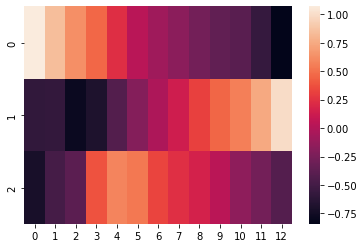

In [11]:
sns.heatmap(neur_clustered.cluster_centers_)

In [31]:
scz_cluster_map = {0: 'early', 1: 'late', 2: 'intermediate'}
neur_clusters = [scz_cluster_map[c] for c in neur_clustered.labels_]

In [32]:
scz_assignments = pd.DataFrame({'gene': neur_pb_median.index, 'cluster': neur_clusters}).set_index('gene').loc[[g for g in scz_genes if g in neur_pb_median.index]]

In [33]:
scz_assignments.to_csv("/project2/gilad/jpopp/ebQTL/data/ldsc/genesets/SCZ.tsv", sep="\t")

In [34]:
scz_assignments.value_counts()

cluster     
late            328
early           269
intermediate    118
dtype: int64

In [16]:
eb_eqtls_loc = "/project2/gilad/jpopp/ebQTL/results/static_qtl_calling/eb_cellid/pseudobulk_tmm/basic/8pcs/mash-signif_variant_gene_pairs.tsv"
gtex_subsampled_eqtls_loc = "/project2/gilad/jpopp/ebQTL/results/subset_qtl_calling/significant_hits/8pcs/signif_variant_gene_pairs.tsv"

In [58]:
gtex_eqtls = pd.read_csv(gtex_subsampled_eqtls_loc, sep="\t")
eb_eqtls = pd.read_csv(eb_eqtls_loc, sep="\t")

In [18]:
gtex_eqtls

,phenotype_id,variant_id,slope,slope_se,pval_nominal,tissue,gene_cutoff
0,ENSG00000189339,chr1_1649846_G_A_b38,-1.132855,0.195716,1.111356e-06,Skin_Not_Sun_Exposed_Suprapubic,0.000015
1,ENSG00000189339,chr1_1650777_G_A_b38,-1.174958,0.192014,3.908057e-07,Skin_Not_Sun_Exposed_Suprapubic,0.000015
2,ENSG00000189339,chr1_1651137_C_T_b38,-1.166861,0.190552,3.853152e-07,Skin_Not_Sun_Exposed_Suprapubic,0.000015
3,ENSG00000189339,chr1_1651421_GTAGCCCCTCTGAACGGTCTGTGACACACGCAT...,-1.183289,0.222562,4.918904e-06,Skin_Not_Sun_Exposed_Suprapubic,0.000015
4,ENSG00000189339,chr1_1651574_G_A_b38,-1.166506,0.191718,4.359367e-07,Skin_Not_Sun_Exposed_Suprapubic,0.000015
...,...,...,...,...,...,...,...
311105,ENSG00000188130,chr22_50255125_A_G_b38,-0.860324,0.178430,2.314174e-05,Brain_Anterior_cingulate_cortex_BA24,0.000033
311106,ENSG00000188130,chr22_50255868_A_G_b38,-0.860324,0.178430,2.314174e-05,Brain_Anterior_cingulate_cortex_BA24,0.000033
311107,ENSG00000188130,chr22_50256841_A_C_b38,-0.860324,0.178430,2.314174e-05,Brain_Anterior_cingulate_cortex_BA24,0.000033
311108,ENSG00000188130,chr22_50257479_G_T_b38,-0.860324,0.178430,2.314174e-05,Brain_Anterior_cingulate_cortex_BA24,0.000033


In [27]:
eb_eqtls

,EB_HGNC,EB_VARIANT_ID,EB_CELLTYPE
0,A1BG,rs10419295,"Acinar-cells,Adrenocortical-cells,CNS-glia,CNS..."
1,A1BG,rs114403025,"Acinar-cells,Adrenocortical-cells,CNS-glia,CNS..."
2,A1BG,rs114515295,"Acinar-cells,CNS-glia,CNS-neurons,Cardiomyocyt..."
3,A1BG,rs114592323,"Acinar-cells,Adrenocortical-cells,CNS-glia,CNS..."
4,A1BG,rs116805469,"Acinar-cells,Adrenocortical-cells,Bronchiolar-..."
...,...,...,...
84859,ZYG11B,rs10157602,"Acinar-cells,CNS-glia,CNS-neurons,Ciliated-epi..."
84860,ZYG11B,rs12069504,"Acinar-cells,Adrenocortical-cells,CNS-glia,CNS..."
84861,ZYG11B,rs12096727,"Acinar-cells,Adrenocortical-cells,CNS-glia,CNS..."
84862,ZYG11B,rs269299,"Acinar-cells,CNS-neurons"


In [40]:
gene_dict = pd.read_csv("/project2/gilad/jpopp/ebQTL/data/gencode/gencode.hg38.filtered.gtf", sep="\t")[['hgnc', 'ensg']]

In [41]:
gene_dict

,hgnc,ensg
0,OR4F5,ENSG00000186092
1,OR4F29,ENSG00000284733
2,OR4F16,ENSG00000284662
3,SAMD11,ENSG00000187634
4,NOC2L,ENSG00000188976
...,...,...
18452,MAPK8IP2,ENSG00000008735
18453,ARSA,ENSG00000100299
18454,SHANK3,ENSG00000251322
18455,ACR,ENSG00000100312


In [42]:
gene_list

,gene,cluster
0,DPYD,late
1,RBFOX1,late
2,SPATS2L,early
3,PPP1R13B,early
4,SF3B1,early
...,...,...
710,NDUFAF2,late
711,ZNHIT3,late
712,ZZEF1,late
713,MGRN1,late


In [46]:
gene_list = gene_list.merge(gene_dict, 'left', left_on='gene', right_on='hgnc')[['cluster', 'hgnc', 'ensg']]

In [54]:
gene_list = gene_list[['cluster', 'hgnc', 'ensg']]

In [55]:
gene_list.to_csv("/project2/gilad/jpopp/ebQTL/data/ldsc/genesets/SCZ.tsv", sep="\t", index=False)

In [56]:
gene_list = pd.read_csv("/project2/gilad/jpopp/ebQTL/data/ldsc/genesets/SCZ.tsv", sep="\t")
subset = 'early'
gene_list_keepers = gene_list.loc[gene_list['cluster'] == subset]
gene_list_keepers

,cluster,hgnc,ensg
2,early,SPATS2L,ENSG00000196141
3,early,PPP1R13B,ENSG00000088808
4,early,SF3B1,ENSG00000115524
5,early,CDK2AP1,ENSG00000111328
6,early,HSPD1,ENSG00000144381
...,...,...,...
696,early,BRINP1,ENSG00000078725
699,early,CPT2,ENSG00000157184
701,early,DEPDC1B,ENSG00000035499
703,early,RPL22L1,ENSG00000163584


In [59]:
eb_eqtls.loc[[g in list(gene_list_keepers['hgnc']) for g in list(eb_eqtls['EB_HGNC'])]]

,EB_HGNC,EB_VARIANT_ID,EB_CELLTYPE
1738,ADGRV1,rs7729763,"Acinar-cells,Adrenocortical-cells,CNS-glia,CNS..."
1915,ADPRHL2,rs115724336,Retinal-cells
1916,ADPRHL2,rs11803002,Retinal-cells
1917,ADPRHL2,rs146857517,Retinal-cells
1918,ADPRHL2,rs77400661,Retinal-cells
...,...,...,...
79060,ZDHHC4,rs7800401,"Acinar-cells,Adrenocortical-cells,Bronchiolar-..."
79061,ZDHHC4,rs7800917,"Acinar-cells,Adrenocortical-cells,Bronchiolar-..."
79062,ZDHHC4,rs7804036,"Acinar-cells,Adrenocortical-cells,Bronchiolar-..."
79063,ZDHHC4,rs9690195,"Acinar-cells,Adrenocortical-cells,CNS-glia,CNS..."


In [60]:
gtex_eqtls.loc[[g in list(gene_list_keepers['ensg']) for g in list(gtex_eqtls['phenotype_id'])]]

,phenotype_id,variant_id,slope,slope_se,pval_nominal,tissue,gene_cutoff
4516,ENSG00000157193,chr1_53291070_A_T_b38,-0.981067,0.216077,0.000055,Thyroid,0.000059
4517,ENSG00000157193,chr1_53292005_C_A_b38,-0.956098,0.208427,0.000048,Thyroid,0.000059
4518,ENSG00000157193,chr1_53298056_C_G_b38,-1.000587,0.194608,0.000009,Thyroid,0.000059
4519,ENSG00000157193,chr1_53298400_A_G_b38,-1.025714,0.199925,0.000009,Thyroid,0.000059
4520,ENSG00000157193,chr1_53305892_C_T_b38,-0.941327,0.195805,0.000024,Thyroid,0.000059
...,...,...,...,...,...,...,...
309917,ENSG00000108587,chr17_30519036_C_A_b38,-0.788905,0.178326,0.000079,Brain_Anterior_cingulate_cortex_BA24,0.000093
309918,ENSG00000108587,chr17_30519144_C_T_b38,-0.788905,0.178326,0.000079,Brain_Anterior_cingulate_cortex_BA24,0.000093
309919,ENSG00000108587,chr17_30523634_TCTGCCCGGCCGCCC_T_b38,-0.803600,0.168227,0.000027,Brain_Anterior_cingulate_cortex_BA24,0.000093
310508,ENSG00000126457,chr19_49700296_T_C_b38,0.909062,0.198151,0.000048,Brain_Anterior_cingulate_cortex_BA24,0.000048


In [64]:
dev_gene_list = pd.read_csv("/project2/gilad/jpopp/ebQTL/temp/tissue_dev.tsv").rename(columns={'GOBP_TISSUE_DEVELOPMENT': 'gene'})
dev_gene_list

,gene
0,ADA
1,CDH2
2,ABI1
3,CDH3
4,MIR541
...,...
1993,FGF19
1994,MED12
1995,NR1H4
1996,NR1D2


In [66]:
gene_list = dev_gene_list.merge(gene_dict, 'left', left_on='gene', right_on='hgnc')[['hgnc', 'ensg']]

In [67]:
gene_list

,hgnc,ensg
0,ADA,ENSG00000196839
1,CDH2,ENSG00000170558
2,ABI1,ENSG00000136754
3,CDH3,ENSG00000062038
4,NaN,NaN
...,...,...
1993,FGF19,ENSG00000162344
1994,NaN,NaN
1995,NR1H4,ENSG00000012504
1996,NR1D2,ENSG00000174738


In [68]:
gene_list.to_csv("/project2/gilad/jpopp/ebQTL/data/ldsc/genesets/GOBP-TISSUE-DEV.tsv", sep="\t", index=False)